In [2]:
%matplotlib inline

import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

import glob
import random
import cv2
import numpy as np
import networkx as nx
import open3d as o3d
import torch
import torch.nn.functional as F
from datetime import datetime

import roma
import kornia
import utils.colmap as colmap_utils


from tqdm import tqdm
from copy import deepcopy
from PIL import Image
from matplotlib import pyplot as plt

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_ratio, load_and_preprocess_images_square
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

from utils.umeyama import umeyama
from utils.metric_torch import evaluate_auc, evaluate_pcd
from utils.eval_utils import evaluate_evo

torch._dynamo.config.accumulated_cache_size_limit = 512
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
def run_VGGT(images, device, dtype):
    # images: [B, 3, H, W]

    # Run VGGT for camera and depth estimation
    model = VGGT()
    _URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
    model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
    model.eval()
    model = model.to(device).to(dtype)
    print(f"Model loaded")

    with torch.no_grad():
        predictions = model(images.to(device, dtype), verbose=True)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(predictions['pose_enc'], images.shape[-2:])
        extrinsic = extrinsic.squeeze(0).cpu().numpy()
        intrinsic = intrinsic.squeeze(0).cpu().numpy()
        depth_map = predictions['depth'].squeeze(0).cpu().numpy()
        depth_conf = predictions['depth_conf'].squeeze(0).cpu().numpy()
    
    return extrinsic, intrinsic, depth_map, depth_conf

In [5]:
# Get image paths and preprocess them
data_dir_gt = "../data/MipNeRF360"
data_dir_pred = "../data/MipNeRF360_pi3"
mode="VIS"  # "EVAL" or "DEBUG" or "VIS"
# f.write(f"Relative Rotation Error (degrees): {auc_results['rel_rangle_deg']}\n")
# f.write(f"Relative Translation Error (degrees): {auc_results['rel_tangle_deg']}\n")
# f.write(f"AUC at 30 degrees: {auc_results['Auc_30']}\n")

results_rel_rangle_deg = []
results_rel_tangle_deg = []
results_Auc_30 = []
scenes = sorted(os.listdir(data_dir_pred))
for scene in scenes:
    if os.path.isdir(os.path.join(data_dir_gt, scene)):
        print(f"Processing scene: {scene}")
        sparse_dir_gt = os.path.join(data_dir_gt, scene, "sparse", "0")
        images_dir = os.path.join(data_dir_gt, scene, "images")

        cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
        images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
        pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))

        sparse_dir_pred = os.path.join(data_dir_pred, scene, "sparse", "0")
        cameras_pred = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_pred, "cameras.bin"))
        images_pred = colmap_utils.read_images_binary(os.path.join(sparse_dir_pred, "images.bin"))
        images_pred_updated = {id: images_pred[id] for id in list(images_gt.keys())}
        pcd_pred = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_pred, "points3D.bin"))

        # print(f"GT's intrinsics: {cameras_gt[1].params}")
        # print(f"Pred's intrinsics: {cameras_pred[1].params}")
        # diff = cameras_gt[1].params - cameras_pred[1].params
        # print("Intrinsic Difference", np.linalg.norm(diff[:2] / cameras_gt[1].params[2:]))

        translation_gt = torch.tensor([image.tvec for image in images_gt.values()], device=device)
        rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt.values()], device=device)
        gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt), 1, 1)
        gt_se3[:, :3, :3] = rotation_gt
        gt_se3[:, 3, :3] = translation_gt

        translation_pred = torch.tensor([image.tvec for image in images_pred_updated.values()], device=device)
        rotation_pred = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_pred_updated.values()], device=device)
        pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_pred_updated), 1, 1)
        pred_se3[:, :3, :3] = rotation_pred
        pred_se3[:, 3, :3] = translation_pred

        if mode == "EVAL":
            auc_results, _, c, R, t = evaluate_auc(pred_se3, gt_se3, device, return_aligned=True)

            for point_id, point in pcd_pred.items():
                point.xyz = (c * R @ point.xyz + t.squeeze())
            
            pcd_xyz_gt = np.stack([point.xyz for point in pcd_gt.values()], axis=0)
            pcd_rgb_gt = np.stack([point.rgb for point in pcd_gt.values()], axis=0)
            pcd_xyz_pred = np.stack([point.xyz for point in pcd_pred.values()], axis=0)
            pcd_rgb_pred = np.stack([point.rgb for point in pcd_pred.values()], axis=0)

            mask = ((pcd_xyz_pred < pcd_xyz_gt.max(axis=0)) & (pcd_xyz_pred > pcd_xyz_gt.min(axis=0))).all(axis=1)
            pcd_xyz_pred = pcd_xyz_pred[mask]
            pcd_rgb_pred = pcd_rgb_pred[mask]
            
            pcd_src = o3d.geometry.PointCloud()
            pcd_src.points = o3d.utility.Vector3dVector(pcd_xyz_gt)
            pcd_src.colors = o3d.utility.Vector3dVector(pcd_rgb_gt)

            pcd_tgt = o3d.geometry.PointCloud()
            pcd_tgt.points = o3d.utility.Vector3dVector(pcd_xyz_pred)
            pcd_tgt.colors = o3d.utility.Vector3dVector(pcd_rgb_pred)

            trans_init, threshold  = np.eye(4), 0.1
            reg_p2p = o3d.pipelines.registration.registration_icp(
                pcd_tgt,
                pcd_src,
                threshold,
                trans_init,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            )
            pcd_tgt.transform(reg_p2p.transformation)

            completeness = pcd_src.compute_point_cloud_distance(pcd_tgt)
            accuracy = pcd_tgt.compute_point_cloud_distance(pcd_src)

            accuracy_mean = np.mean(accuracy)  # to be written to txt file
            completeness_mean = np.mean(completeness)  # to be written to txt file
            chamfer_distance = np.mean(np.concatenate([accuracy, completeness]))  # to be written to txt file

            results_Auc_30.append(auc_results['Auc_30'])
            results_rel_rangle_deg.append(auc_results['rel_rangle_deg'].item())
            results_rel_tangle_deg.append(auc_results['rel_tangle_deg'].item())
        elif mode == "DEBUG":
            c2w_gt = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt), 1, 1)
            c2w_gt[:, :3, :3] = rotation_gt.transpose(1, 2)
            c2w_gt[:, :3, 3] = - (rotation_gt.transpose(1, 2) @ translation_gt[..., None]).squeeze(-1)

            c2w_pred_inv = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_pred_updated), 1, 1)
            c2w_pred_inv[:, :3, :3] = rotation_pred
            c2w_pred_inv[:, :3, 3] = translation_pred

            # c2w_gt = torch.matmul(c2w_pred, tgt_transform)
            tgt_transform = torch.matmul(c2w_pred_inv, c2w_gt)

            diff = (tgt_transform - torch.eye(4, device=device).unsqueeze(0)).cpu().numpy()
            plt.style.use("seaborn-v0_8-whitegrid")
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.hist(diff[:, :3, :3].reshape(-1), bins=100, range=(-0.02, 0.02), color='skyblue', edgecolor='black')
            plt.title(f"Rotation Residuals of {scene}")
            plt.xlabel("Rotation Residual Value")
            plt.ylabel("Frequency")

            plt.subplot(1, 2, 2)
            plt.hist(diff[:, :3, 3].reshape(-1), bins=100, range=(-0.1, 0.1), color='salmon', edgecolor='black')
            plt.title(f"Translation Residuals of {scene}")
            plt.xlabel("Translation Residual Value")
            plt.ylabel("Frequency")
        elif mode == "VIS":
            auc_results, pred_se3_aligned, c, R, t = evaluate_auc(pred_se3, gt_se3, device, return_aligned=True);

            c2ws_gt = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt), 1, 1)
            c2ws_gt[:, :3, :3] = gt_se3[:, :3, :3].transpose(1, 2)
            c2ws_gt[:, :3, 3] = - (gt_se3[:, :3, :3].transpose(1, 2) @ gt_se3[:, 3, :3][..., None]).squeeze(-1)

            c2ws_pred = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_pred_updated), 1, 1)
            c2ws_pred[:, :3, :3] = pred_se3_aligned[:, :3, :3].transpose(1, 2)
            c2ws_pred[:, :3, 3] = - (pred_se3_aligned[:, :3, :3].transpose(1, 2) @ pred_se3_aligned[:, 3, :3][..., None]).squeeze(-1)
            
            target_dir = f"./trajectories_{data_dir_pred.split('/')[-1]}"
            os.makedirs(target_dir, exist_ok=True)
            ape_stats = evaluate_evo(c2ws_pred.cpu().numpy(), c2ws_gt.cpu().numpy(), plot_dir=target_dir, 
                                     label=scene, min_map=0, max_map=0.25, abs=True)

        # camera_centers_gt = - (gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)

        # print(f"Range of GT camera centers: {camera_centers_gt.max(0) - camera_centers_gt.min(0)}")

Processing scene: bicycle
    --  Umeyama Scale:  4.4790885763053545
    --  Umeyama Rotation: 
 [[ 0.90452134  0.24585711 -0.34841833]
 [-0.16820372  0.95651847  0.23828541]
 [ 0.39185273 -0.15692902  0.90654548]]
    --  Umeyama Translation: 
 [[ 0.06824063]
 [-0.12064672]
 [ 0.11240005]]
    --  Pair Rot   Error (Deg) of Vanilla:       0.75
    --  Pair Trans Error (Deg) of Vanilla:       1.01
    --  AUC at 30: 0.9786
Rotation Error - Mean: 0.47°, Median: 0.39°


Eval: RMSE ATE [m] 0.09207599525377644

Processing scene: bonsai
    --  Umeyama Scale:  4.998149559711547
    --  Umeyama Rotation: 
 [[ 0.4855931   0.29851034 -0.8216392 ]
 [-0.52974879  0.84814016 -0.00494589]
 [ 0.69538881  0.43766406  0.56998647]]
    --  Umeyama Translation: 
 [[0.23851616]
 [0.59149851]
 [0.77686161]]
    --  Pair Rot   Error (Deg) of Vanilla:       1.13
    --  Pair Trans Error (Deg) of Vanilla:       1.43
    --  AUC at 30: 0.9588
Rotation Error - Mean: 0.88°, Median: 0.84°


Eval: RMSE ATE [m] 0.08302261228128252

Processing scene: counter
    --  Umeyama Scale:  3.8349987369900242
    --  Umeyama Rotation: 
 [[ 0.15718551  0.32744744 -0.93170322]
 [-0.52137502  0.82875488  0.20330616]
 [ 0.83872567  0.45381     0.3009912 ]]
    --  Umeyama Translation: 
 [[0.09936663]
 [0.59472894]
 [0.52718047]]
    --  Pair Rot   Error (Deg) of Vanilla:       0.58
    --  Pair Trans Error (Deg) of Vanilla:       0.87
    --  AUC at 30: 0.9861
Rotation Error - Mean: 0.46°, Median: 0.44°


Eval: RMSE ATE [m] 0.03978136897577139

Processing scene: flowers
    --  Umeyama Scale:  5.000815900665561
    --  Umeyama Rotation: 
 [[ 0.75473134 -0.22342054  0.61681749]
 [-0.30035442  0.71821441  0.62765852]
 [-0.58323904 -0.65897743  0.47495361]]
    --  Umeyama Translation: 
 [[ 0.74871989]
 [-0.41141813]
 [-0.13049474]]
    --  Pair Rot   Error (Deg) of Vanilla:      22.68
    --  Pair Trans Error (Deg) of Vanilla:      21.26
    --  AUC at 30: 0.2398
Rotation Error - Mean: 17.45°, Median: 17.49°


Eval: RMSE ATE [m] 1.2476462283081082

Processing scene: garden
    --  Umeyama Scale:  3.955736503316339
    --  Umeyama Rotation: 
 [[ 0.99996037  0.00715221 -0.00530085]
 [-0.00752638  0.99720771 -0.07429766]
 [ 0.00475467  0.07433459  0.99722205]]
    --  Umeyama Translation: 
 [[0.02733316]
 [0.46271806]
 [0.61352615]]
    --  Pair Rot   Error (Deg) of Vanilla:       0.51
    --  Pair Trans Error (Deg) of Vanilla:       0.79
    --  AUC at 30: 0.9865
Rotation Error - Mean: 0.59°, Median: 0.57°


Eval: RMSE ATE [m] 0.04740399408726015

Processing scene: kitchen
    --  Umeyama Scale:  3.2135665766483315
    --  Umeyama Rotation: 
 [[-0.95991795  0.14889087 -0.23746369]
 [-0.13271596  0.50477813  0.85298621]
 [ 0.24686839  0.850312   -0.4647854 ]]
    --  Umeyama Translation: 
 [[-0.10190642]
 [ 0.6973462 ]
 [ 0.43735713]]
    --  Pair Rot   Error (Deg) of Vanilla:       0.51
    --  Pair Trans Error (Deg) of Vanilla:       0.78
    --  AUC at 30: 0.9872
Rotation Error - Mean: 0.33°, Median: 0.31°


Eval: RMSE ATE [m] 0.03927479868393163

Processing scene: room
    --  Umeyama Scale:  4.578192964110367
    --  Umeyama Rotation: 
 [[ 0.7362084  -0.2652043   0.62262661]
 [ 0.28824062  0.95527579  0.06607184]
 [-0.61230262  0.13082367  0.7797247 ]]
    --  Umeyama Translation: 
 [[0.46067077]
 [0.42977807]
 [0.33767299]]
    --  Pair Rot   Error (Deg) of Vanilla:       1.48
    --  Pair Trans Error (Deg) of Vanilla:       1.98
    --  AUC at 30: 0.9393
Rotation Error - Mean: 1.61°, Median: 1.51°


Eval: RMSE ATE [m] 0.10688062700712127

Processing scene: stump
    --  Umeyama Scale:  6.06828976247747
    --  Umeyama Rotation: 
 [[-0.24421049  0.39841965 -0.88409445]
 [-0.7291508   0.52559969  0.43827393]
 [ 0.63929672  0.75166929  0.16215102]]
    --  Umeyama Translation: 
 [[0.17580429]
 [0.09341539]
 [0.35278258]]
    --  Pair Rot   Error (Deg) of Vanilla:       0.85
    --  Pair Trans Error (Deg) of Vanilla:       1.96
    --  AUC at 30: 0.9491
Rotation Error - Mean: 0.64°, Median: 0.62°


Eval: RMSE ATE [m] 0.11819001996562259

Processing scene: treehill
    --  Umeyama Scale:  4.292228600300378
    --  Umeyama Rotation: 
 [[ 0.97390698  0.00340219  0.22692192]
 [-0.02464956  0.99555805  0.09086522]
 [-0.22560482 -0.09408781  0.96966487]]
    --  Umeyama Translation: 
 [[-0.29311608]
 [-0.20565193]
 [ 0.01391601]]
    --  Pair Rot   Error (Deg) of Vanilla:       0.71
    --  Pair Trans Error (Deg) of Vanilla:       1.15
    --  AUC at 30: 0.9749
Rotation Error - Mean: 0.45°, Median: 0.37°


Eval: RMSE ATE [m] 0.07711708915549971

In [5]:
print(f"Average Relative Rotation Error (degrees): {np.mean(results_rel_rangle_deg)}")
print(f"Average Relative Translation Error (degrees): {np.mean(results_rel_tangle_deg)}")
print(f"Average AUC at 30 degrees: {np.mean(results_Auc_30)}")

Average Relative Rotation Error (degrees): 0.4500442147254944
Average Relative Translation Error (degrees): 0.36833086609840393
Average AUC at 30 degrees: 0.9965130023640664


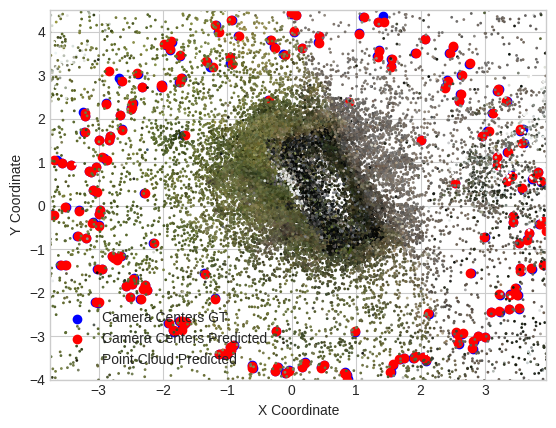

In [11]:
camera_centers_gt = - (gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
camera_centers_pred = - (pred_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ pred_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
c, R, t = umeyama(camera_centers_gt.T, camera_centers_pred.T)
camera_centers_gt_aligned = (c * (R @ camera_centers_gt.T) + t).T
variance = np.var(camera_centers_pred, axis=0)
ground_plane_indices = np.argsort(variance)[1:]
pcd_interval = 10

if pcd_rgb_pred.max() > 1.0:
    pcd_rgb_pred = pcd_rgb_pred / 255.0

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.scatter(camera_centers_gt_aligned[:, ground_plane_indices[0]], camera_centers_gt_aligned[:, ground_plane_indices[1]], c='blue', label='Camera Centers GT')
plt.scatter(camera_centers_pred[:, ground_plane_indices[0]], camera_centers_pred[:, ground_plane_indices[1]], c='red', label='Camera Centers Predicted')
plt.scatter(pcd_xyz_pred[::pcd_interval, ground_plane_indices[0]], pcd_xyz_pred[::pcd_interval, ground_plane_indices[1]], c=pcd_rgb_pred[::pcd_interval], s=1, label='Point Cloud Predicted')
plt.xlim(camera_centers_pred[:, ground_plane_indices[0]].min(), camera_centers_pred[:, ground_plane_indices[0]].max())
plt.ylim(camera_centers_pred[:, ground_plane_indices[1]].min(), camera_centers_pred[:, ground_plane_indices[1]].max())
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()